# Construct dataset

In [157]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pylab
from pycbc.filter import sigma
from pycbc.waveform import get_td_waveform
from pycbc.types.timeseries import load_timeseries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import uniform, randint
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import fsolve
import math
from gekko import GEKKO
#import false signal functions
from ipynb.fs.full.falsig_functions import random_false_sig, flip_gw
from ipynb.fs.full.data_functions import noise, burried_gw, partial_burried_false, partial_burried_gw, burried_false, burried_flip, visualize, bol, empty_gaussian

In [158]:
# Function used to append data in desired format to X,y
def appendXy(wave,target):
    X.append(np.asarray(wave))
    y.append(target)

Trial 4 information:
- change data sampling method
    - mass: 
        - chirp masses from 7-100
        - chirp mass: (m1m2)^(3/5)/(m1+m2)^(1/5)
        - ita 100 in 0-1/4     
        - ita (symmetric mass ratio): m1m2/(m1+m2)^2
    - distance
- full signals 
    - SNR 10-1000
    - randomly generate two masses 10-100 (no longer restrictions)
    - also flipped and noise & false signals at SNR 10-100
- partial gw signals
    - SNR 10-100
    - 50%-100% kept on the right side
- partial false signals
    - SNR 10-100
    - 10%-100% kept and randomly burried
- train and test generated in one batch. Then separate.


In [202]:
# find out the distribution range of ita and chirp M for the masses 10-100

Mchirp = []
ita = []
for i in np.arange(20000):
    m1 = uniform(10,100)
    m2 = uniform(10,100)
    M = (m1*m2)**(3/5)/(m1+m2)**(1/5)
    Mchirp.append(M)
    it = (m1*m2)/(m1+m2)**2
    ita.append(it)
    
values = pd.DataFrame()
values["chirp_mass"] = Mchirp
values["ita"] = ita

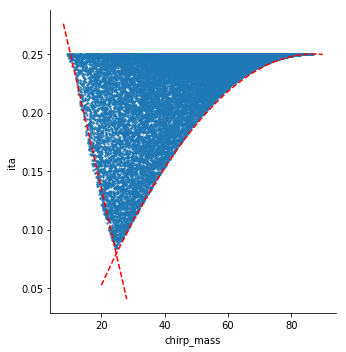

In [203]:
# Create scatterplotof dataframe
sns.lmplot('chirp_mass', 'ita', data=values, fit_reg=False, 
           scatter_kws={"s": 2})

x1 = np.linspace(20, 90, 1000)
y1 = -4.4*10**(-5)*(x-87)**2+0.25
plt.plot(x1, y1, 'r--')

x2 = np.linspace(8, 28, 100)
y2 = 0.37-1/85*x2
plt.plot(x2, y2, 'r--')

plt.show()

As shown above, the desired data are constrained in the region between the two functions.

We will sample a"box" of ita and chirp mass and then eliminate the ones outside the functions

In [216]:
def masses(chirp, it):
    M1 = (chirp/(2*it**(3/5)))*(1-(1-4*it)**(1/2))
    M2 = (chirp/(2*it**(3/5)))*(1+(1-4*it)**(1/2))
    return [M1,M2]

In [218]:
# Randomly sample within max-min ita and M box
Mpair = []
min_M = min(Mchirp)
max_M = max(Mchirp)
min_ita = min(ita)
max_ita = max(ita)

for i in np.arange(20000):
    M = uniform(min_M,max_M)
    it = uniform(min_ita,max_ita)
    Mpair.append([M,it])

/Users/DRRRR/anaconda/envs/machinelearning/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


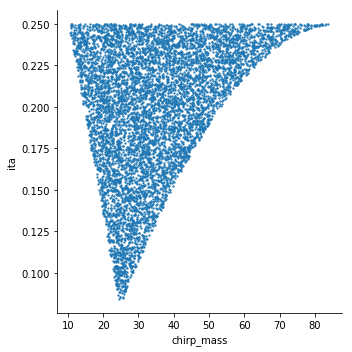

In [219]:
# Sample data to be within range
pairs = pd.DataFrame(Mpair, columns = ["chirp_mass","ita"])

pairs1 = pairs[pairs.ita > 0.37-1/85*pairs.chirp_mass]
pair = pairs1[pairs.ita > -4.4*10**(-5)*(pairs.chirp_mass-87)**2+0.25]
pair = pair.reset_index(drop=True)
sns.lmplot('chirp_mass', 'ita', data = pair, fit_reg = False, 
           scatter_kws={"s": 2})
plt.show()

In [220]:
mass = []
for i in tqdm(range(len(pair.ita))):
    add = masses(pair.chirp_mass[i],pair.ita[i])
    mass.append(add)
    
print("A total of ",len(mass), " mass pairs are sampled.")


100%|██████████| 7497/7497 [00:00<00:00, 10119.27it/s]